# Modelo 01

<hr>

## Cleaning and Processing Machine Learning data

In [87]:
import pandas as pd
import os
import json

In [88]:
# houses = json.load(open('../../EDOMEX_houses.json'))
# apartments = json.load(open('../../EDOMEX_apartments.json'))

In [89]:
df_houses = pd.read_json('../../EDOMEX_houses.json')
df_apartments = pd.read_json('../../EDOMEX_apartments.json')

In [90]:
df_complete = df_houses.append(df_apartments)
# df_complete

In [91]:
df_complete = df_complete[df_complete['currency']=="MXN"]
df_complete.head()

,url,type_of_offer,type_of_prop,name,price,currency,Estado,Ciudad,Colonia,Superficie total,...,Cantidad de pisos,Cuota mensual de mantenimiento,Bodegas,Orientación,Tipo de casa,Tipo de propiedad,Departamentos por piso,Número de piso de la unidad,Disposición,Tipo de departamento
0,https://casa.metroscubicos.com/MLM-959176385-v...,sale,houses,"Venta Casa Ezequiel Chávez, Ciudad Satélite.",10800000,MXN,Estado De México,Naucalpan,Ciudad Satélite,525.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://casa.metroscubicos.com/MLM-960867980-e...,sale,houses,Espectacular Residencia En Lomas De Tecamachalco,19900000,MXN,Estado De México,Naucalpan,Lomas De Tecamachalco,282.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://casa.metroscubicos.com/MLM-959186781-r...,sale,houses,Residencia En Venta Vista Del Valle,14500000,MXN,Estado De México,Naucalpan,"Vista Del Valle II, III, IV y IX",750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://casa.metroscubicos.com/MLM-958325468-v...,sale,houses,Venta Casa Paseo Satelite,8900000,MXN,Estado De México,Naucalpan,Santa Cruz Del Monte,196.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://casa.metroscubicos.com/MLM-941274503-c...,sale,houses,Casa En Venta En Tecamachalco,12800000,MXN,Estado De México,Naucalpan,Lomas De Tecamachalco,463.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Split data Train and Test

In [180]:
from sklearn.model_selection import train_test_split

# Read data
X_full = df_complete
# X_test_full = pd.read_csv("")

# Obtain Target and Predictions
y = X_full.price

features = ['type_of_prop',
       'Estado', 'Ciudad', 'Colonia', 'Superficie total','Ambientes', 'Recamaras', 'Banos',
       'Estacionamientos', 'Antiguedad', 'Cantidad de pisos',
       'Cuota mensual de mantenimiento', 'Bodegas']

X = X_full[features]
# X_test = X_test_full[features]

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)


In [93]:
from sklearn.ensemble import RandomForestRegressor

# Define the models
model_1 = RandomForestRegressor(n_estimators=50, random_state=0)
model_2 = RandomForestRegressor(n_estimators=100, random_state=0)
model_3 = RandomForestRegressor(n_estimators=100, criterion='mae', random_state=0)
model_4 = RandomForestRegressor(n_estimators=200, min_samples_split=20, random_state=0)
model_5 = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=0)

models = [model_1, model_2, model_3, model_4, model_5]

## 1) Cleaning

We require the transformation of Categorical Variables to feed the model, we will use One Hot Encoder because the variables we need to transform do not have an ordinal rank, and we don´t need to identify a hierarchy level between houses and apartments, for example. 

### Categorical Variables

In [94]:
# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['type_of_prop', 'Estado', 'Ciudad', 'Colonia']


### One Hot Encoding

In [95]:
from sklearn.preprocessing import OneHotEncoder

s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)


### Goodbye NAs 

In [96]:
OH_X_train=OH_X_train.fillna(0)
OH_X_valid=OH_X_valid.fillna(0)

print("No more NAs, now just 0s :D")

No more NAs, now just 0s :D


In [97]:
from sklearn.metrics import mean_absolute_error

# Function for comparing different models
def score_model(model, X_t=OH_X_train, X_v=OH_X_valid, y_t=y_train, y_v=y_valid):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    return mean_absolute_error(y_v, preds)

for i in range(0, len(models)):
    mae = score_model(models[i])
    print("Model %d MAE: %d" % (i+1, mae))

Model 1 MAE: 1331317
Model 2 MAE: 1315987
Model 3 MAE: 1277496
Model 4 MAE: 1417299
Model 5 MAE: 1348177


## 2) Cross Validation

Cross Validation is used to improve the score measures of our model by running the same process on different subsets of data to get multiple scores, or in other workds, desing different scenarios in order to use the 100% of the dataset as a test or validation data. This method should be used if we have a relative small data set.

In [98]:
# Creating a Pipeline

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

my_pipeline = Pipeline(steps=[('model', RandomForestRegressor(n_estimators=50,
                                                              random_state=0))
                             ])

In [101]:
from sklearn.model_selection import cross_val_score
X=X.fillna(0)

# Get list of categorical variables
s = (X.dtypes == 'object')
object_cols = list(s[s].index)

# Encoding Categorical Variables with OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoder to each column with categorical data
OH_X_pandas = pd.get_dummies(X)

# OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
# OH_cols = pd.DataFrame(OH_encoder.fit_transform(X[object_cols]))
# One-hot encoding removed index; put it back
# OH_cols.index = X.index
# Remove categorical columns (will replace with one-hot encoding)
# num_X = X.drop(object_cols, axis=1)
# Add one-hot encoded columns to numerical features
# OH_X = pd.concat([num_X, OH_cols], axis=1)

# Verify if NA cleaning can be inside the pipeline
# OH_X=OH_X.fillna(0)

def crossed_score_model(model, X, y):
    
    my_pipeline = Pipeline(steps=[('model', model)])
    
    # Multiply by -1 since sklearn calculates *negative* MAE
    scores = -1 * cross_val_score(my_pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')
#     print("MAE scores:\n", scores)
#     print(scores.mean())
    return scores.mean()

for i in range(0,len(models)):
    cross_score=crossed_score_model(models[i],OH_X_pandas, y)
    print("Model %d Avg Cross Score: %d" % (i+1, cross_score))
    

Model 1 Avg Cross Score: 1628782
Model 2 Avg Cross Score: 1639069
Model 3 Avg Cross Score: 1640996
Model 4 Avg Cross Score: 1611346
Model 5 Avg Cross Score: 1644486


## 3) XG Boost

Gradient boosting is a method that goes through cycles to iteratively add models into an ensemble.

It begins by initializing the ensemble with a single model, whose predictions can be pretty naive. (Even if its predictions are wildly inaccurate, subsequent additions to the ensemble will address those errors.)

In [102]:
from xgboost import XGBRegressor
X_valid 

xg_model = XGBRegressor()
xg_model.fit(OH_X_train, y_train)

from sklearn.metrics import mean_absolute_error

# Get predictions
predictions = xg_model.predict(OH_X_valid) 
mae = mean_absolute_error(predictions, y_valid) 

print(mae)

1473643.119047619


In [103]:
print("MAE still very high :(")

MAE still very high :(


## Cleaning national data

<AxesSubplot:>

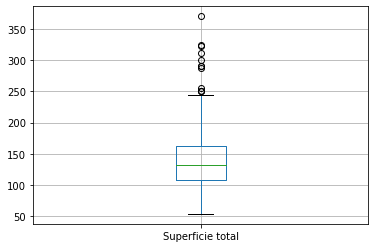

In [188]:
national_data['Superficie total'].plot.box(grid=True)

<AxesSubplot:>

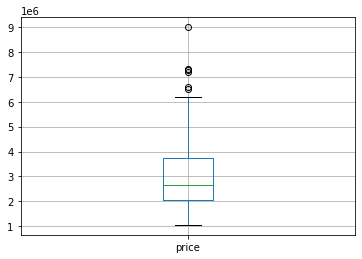

In [212]:
national_data = pd.read_json('../Scraping/Output/full_data.json')
national_data = national_data[national_data['currency']=='MXN']
national_data = national_data[national_data['name'].str.contains('Renta')==False]
national_data_cp = national_data[national_data['cp'].isnull()==False]

national_data = national_data[national_data['price']>1000000]
national_data = national_data[national_data['price']<10000000]
national_data = national_data[national_data['Estado']=='Puebla']
# national_data = national_data[national_data['Superficie total']<300]

national_data['price'].plot.box(grid='True')

In [213]:
national_data.columns

Index(['index', 'url', 'type_of_offer', 'type_of_prop', 'name', 'price',
       'currency', 'Estado', 'Ciudad', 'Colonia', 'Superficie total',
       'Superficie construida', 'Recamaras', 'Banos', 'Estacionamientos',
       'Antiguedad', 'Cuota mensual de mantenimiento', 'Ambientes', 'Bodegas',
       'Cantidad de pisos', 'site', 'Orientación', 'Departamentos por piso',
       'Tipo de departamento', 'Número de piso de la unidad', 'Disposición',
       'Tipo de casa', 'Tipo de propiedad', 'cp'],
      dtype='object')

In [218]:
from sklearn.model_selection import train_test_split

# Read data
X_full = national_data_cp
# X_test_full = pd.read_csv("")

# Obtain Target and Predictions
y = X_full.price

features = ['type_of_prop',
       'Estado', 'Ciudad', 'Colonia', 'Superficie total',
       'Superficie construida', 'Ambientes', 'Recamaras', 'Banos',
       'Estacionamientos', 'Antiguedad', 'Cantidad de pisos',
       'Cuota mensual de mantenimiento', 'Bodegas']

X = X_full[features]

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)


In [219]:
from sklearn.preprocessing import OneHotEncoder

s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

OH_X_train=OH_X_train.fillna(0)
OH_X_valid=OH_X_valid.fillna(0)

In [ ]:
X_train

In [ ]:
from sklearn.metrics import mean_absolute_error

# Function for comparing different models
def score_model(model, X_t=OH_X_train, X_v=OH_X_valid, y_t=y_train, y_v=y_valid):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    return mean_absolute_error(y_v, preds)

for i in range(0, len(models)):
    try:
        mae = score_model(models[i])
        print("Model %d MAE: %d" % (i+1, mae))
    
    except Exception as e:
        print(e)

Model 1 MAE: 1442959
Model 2 MAE: 1447662


## KNearest Neighbor Model

In [112]:
# OH_X_train

k: 1, Train/Test Score: 0.968/0.075
k: 3, Train/Test Score: 0.399/0.038
k: 5, Train/Test Score: 0.251/0.033
k: 7, Train/Test Score: 0.196/0.029
k: 9, Train/Test Score: 0.164/0.033
k: 11, Train/Test Score: 0.138/0.033
k: 13, Train/Test Score: 0.125/0.029
k: 15, Train/Test Score: 0.111/0.027
k: 17, Train/Test Score: 0.110/0.023
k: 19, Train/Test Score: 0.104/0.025


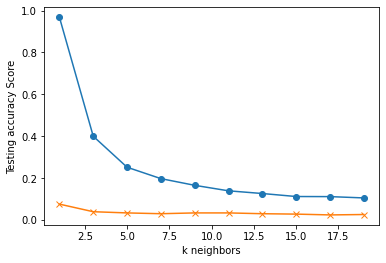

In [113]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# Loop through different k values to see which has the highest accuracy
# Note: We only use odd numbers because we don't want any ties

train_scores = []
test_scores = []

for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(OH_X_train, y_train)
    train_score = knn.score(OH_X_train, y_train)
    test_score = knn.score(OH_X_valid, y_valid)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

In [114]:
# Note that k: 9 provides the best accuracy where the classifier starts to stablize
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(OH_X_train, y_train)
print('k=5 Test Acc: %.3f' % knn.score(OH_X_valid, y_test))

k=5 Test Acc: 0.033


In [115]:
predictions = knn.predict(OH_X_valid)

In [116]:
mean_absolute_error(predictions,y_valid)

1554780.8049713194

In [118]:
national_data.price.describe()

count    6.758000e+03
mean     4.941058e+06
std      5.371521e+07
min      1.000000e+00
25%      1.242750e+06
50%      2.400000e+06
75%      4.596599e+06
max      4.382460e+09
Name: price, dtype: float64

In [146]:
national_data[national_data['price']>100000000]

,index,url,type_of_offer,type_of_prop,name,price,currency,Estado,Ciudad,Colonia,Superficie total,Superficie construida,Recamaras,Banos,Estacionamientos,Antiguedad,Cuota mensual de mantenimiento,Ambientes,Bodegas,Cantidad de pisos,site,Orientación,Departamentos por piso,Tipo de departamento,Número de piso de la unidad,Disposición,Tipo de casa,Tipo de propiedad,cp
176,32,https://casa.metroscubicos.com/MLM-886476606-m...,sale,houses,Mansión De Lujo En Venta Los Cabos Mexico,122000000,MXN,Baja California Sur,Los Cabos,El Pedregal,2546.0,1644.0,8.0,11.0,NaN,13.0,NaN,19.0,NaN,NaN,Data\BajaSur_hs.json,None,NaN,None,NaN,None,None,None,23453.0
177,33,https://casa.metroscubicos.com/MLM-886476588-r...,sale,houses,"Residencia De Lujo San José Del Cabo, California",170325000,MXN,Baja California Sur,Los Cabos,Palmilla,6090.0,2558.0,6.0,7.0,10.0,0.0,NaN,14.0,NaN,NaN,Data\BajaSur_hs.json,None,NaN,None,NaN,None,None,None,23537.0
3971,11,https://departamento.metroscubicos.com/MLM-961...,sale,apartments,Departamento En Preventa Basania Torre Reside...,4382460000,MXN,Guanajuato,León,Villas Del Juncal,112.0,112.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,1.0,Data\Guanajuato_ap.json,None,NaN,None,NaN,None,None,None,37180.0
4503,11,https://casa.metroscubicos.com/MLM-952148666-c...,sale,houses,"Cad Villa Universal. 200 M De Playa. Alberca, ...",120000000,MXN,Guerrero,Acapulco,Club de golf 3 Vidas,5000.0,1200.0,8.0,8.0,4.0,NaN,NaN,NaN,NaN,NaN,Data\Guerrero_hs.json,None,NaN,None,NaN,None,None,None,NaN


<AxesSubplot:>

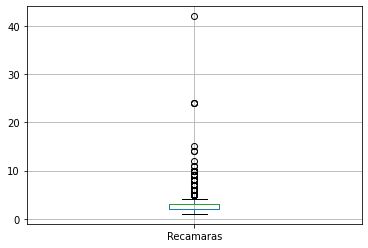

In [140]:
national_data.boxplot(column=['Recamaras'], return_type='axes')

In [142]:
pd.set_option('display.max_columns', None)

In [143]:
national_data[national_data['Recamaras']>20]

,index,url,type_of_offer,type_of_prop,name,price,currency,Estado,Ciudad,Colonia,Superficie total,Superficie construida,Recamaras,Banos,Estacionamientos,Antiguedad,Cuota mensual de mantenimiento,Ambientes,Bodegas,Cantidad de pisos,site,Orientación,Departamentos por piso,Tipo de departamento,Número de piso de la unidad,Disposición,Tipo de casa,Tipo de propiedad,cp
661,166,https://casa.metroscubicos.com/MLM-926981124-s...,sale,houses,Se Vende Hotel En Cd. Jimenez,24500000,MXN,Chihuahua,Jiménez,Ciudad Jiménez,17000.0,3997.0,42.0,50.0,100.0,40.0,NaN,NaN,NaN,NaN,Data\Chi_houses.json,None,NaN,None,NaN,None,None,None,NaN
689,14,https://departamento.metroscubicos.com/MLM-959...,sale,apartments,Departamento En Venta Fracc Res San Jose,24500000,MXN,Coahuila,Saltillo,San Jose de Flores,NaN,1656.0,24.0,18.0,NaN,0.0,NaN,NaN,NaN,NaN,Data\Coahuila_ap.json,None,NaN,None,NaN,None,None,None,NaN
4400,137,https://departamento.metroscubicos.com/MLM-793...,sale,apartments,Se Vende Predio Urbano Con Construcción,7717450,MXN,None,None,None,493.0,785.0,24.0,12.0,NaN,22.0,NaN,NaN,NaN,2.0,Data\Guerrero_ap.json,None,NaN,None,NaN,None,None,None,NaN
4499,7,https://casa.metroscubicos.com/MLM-943475172-s...,sale,houses,"Se Vende Casa Sola, Amplia Y Centrica",6500000,MXN,Guerrero,Acapulco,Las Playas,625.0,550.0,24.0,24.0,1.0,25.0,NaN,1.0,1.0,4.0,Data\Guerrero_hs.json,Sur,NaN,None,NaN,None,None,None,NaN
